# Moral Foundations Analysis - English Texts

This notebook analyzes English children's literature and moral texts for moral foundations using:
1. English master moral vectors (from validation notebook)
2. Cleaned English texts (from processedDataEnglish/)
3. Cosine similarity scoring
4. Two analysis methods: Average scores + Dominant distribution

**Texts analyzed:**
- Aesop's Fables
- Grimm's Household Tales
- Hans Christian Andersen Fairy Tales
- Just So Stories
- Morals and Manners
- Peter Rabbit

**Outputs:**
- Detailed CSV files with text-level moral scores
- PCA visualizations
- Distribution charts
- Summary statistics

## Load English Master Moral Vectors

In [1]:
import pickle
import numpy as np
import pandas as pd
import os
from pathlib import Path

# Load English master moral vectors (from parent directory)
with open('../master_vectors_all_languages.pkl', 'rb') as f:
    all_vectors = pickle.load(f)

# Extract English vectors
if 'english' in all_vectors:
    master_moral_vectors_english = all_vectors['english']
else:
    raise FileNotFoundError("English master vectors not found in pickle file")

# Ensure numpy arrays
for k, v in master_moral_vectors_english.items():
    master_moral_vectors_english[k] = np.array(v, dtype=np.float32)

print("Master Moral Vectors loaded:")
for foundation, vector in master_moral_vectors_english.items():
    print(f"{foundation}: {vector[:5]}...")  # Print first 5 elements

Master Moral Vectors loaded:
care.virtue: [-0.01993794  0.01070593 -0.00855213 -0.00665717 -0.00125954]...
care.vice: [-0.01250592  0.00353126  0.01182757  0.00208265 -0.00288362]...
fairness.virtue: [-0.01801289  0.00632953 -0.0019798  -0.01034678  0.00363413]...
fairness.vice: [-0.00022982  0.00463817  0.02136709 -0.00873424 -0.00330092]...
loyalty.virtue: [-0.01397729  0.00466763  0.00886195 -0.00529534  0.00739838]...
loyalty.vice: [-0.00110871 -0.00215744  0.01932479 -0.00913977 -0.00764371]...
authority.virtue: [-0.01551665  0.01278673  0.00741049 -0.00466473  0.00591277]...
authority.vice: [-0.00704374  0.00444568  0.02150437 -0.00651294 -0.00208919]...
sanctity.virtue: [-0.01712277  0.01087363  0.00984664 -0.00748536 -0.00979777]...
sanctity.vice: [-0.0074419   0.00531518  0.03010704 -0.00677086 -0.00364618]...


## Load and Embed English Texts

In [2]:
from sentence_transformers import SentenceTransformer

EMBEDDINGS_MODEL_NAME = 'l3cube-pune/indic-sentence-similarity-sbert'
model = SentenceTransformer(EMBEDDINGS_MODEL_NAME)
print(f"✓ Model loaded: {EMBEDDINGS_MODEL_NAME}")

/Users/devisivakumar/MyWorkspace/ANLP_Project/anlp-project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Model loaded: l3cube-pune/indic-sentence-similarity-sbert


## Load English Text Files and Generate Embeddings

We'll load all cleaned English texts from the processedDataEnglish folder and generate embeddings for each story/fable.

In [3]:
# Find all CSV files in processedDataEnglish directory
data_dir = Path('./processedDataEnglish')
csv_files = list(data_dir.glob('*_cleaned.csv'))

print(f"Found {len(csv_files)} English text files:")
for f in csv_files:
    print(f"  - {f.name}")

Found 6 English text files:
  - just_so_stories_cleaned.csv
  - hans_christian_andersen_cleaned.csv
  - morals_manners_cleaned.csv
  - grimm_tales_cleaned.csv
  - peter_rabbit_cleaned.csv
  - aesops_fables_cleaned.csv


In [4]:
# Load texts and generate embeddings
file_embeddings = {}
file_texts = {}
file_dataframes = {}

for csv_file in csv_files:
    filename = csv_file.name
    print(f"\nProcessing: {filename}")
    
    # Load CSV
    df = pd.read_csv(csv_file, encoding='utf-8')
    file_dataframes[filename] = df
    
    # Determine text column (different files have different column names)
    text_col = None
    for col in ['text', 'story', 'fable', 'tale', 'content']:
        if col in df.columns:
            text_col = col
            break
    
    # If no standard column, use the last column that looks like text
    if text_col is None:
        # Find columns with string data that aren't IDs or titles
        for col in df.columns:
            if df[col].dtype == 'object' and col.lower() not in ['title', 'number', 'id']:
                # Check if this column has substantial text (average length > 50 chars)
                avg_len = df[col].astype(str).str.len().mean()
                if avg_len > 50:
                    text_col = col
                    break
    
    if text_col is None:
        print(f"  Warning: No text column found in {filename}. Skipping.")
        continue
    
    # Extract texts
    texts = df[text_col].astype(str).tolist()
    file_texts[filename] = texts
    
    # Generate embeddings
    print(f"  Generating embeddings for {len(texts)} {text_col}s...")
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    file_embeddings[filename] = embeddings
    
    print(f"  ✓ Embeddings shape: {embeddings.shape}")

print(f"\nTotal files processed: {len(file_embeddings)}")


Processing: just_so_stories_cleaned.csv
  Generating embeddings for 12 texts...


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


  ✓ Embeddings shape: (12, 768)

Processing: hans_christian_andersen_cleaned.csv
  Generating embeddings for 202 texts...


Batches: 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


  ✓ Embeddings shape: (202, 768)

Processing: morals_manners_cleaned.csv
  Generating embeddings for 131 texts...


Batches: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


  ✓ Embeddings shape: (131, 768)

Processing: grimm_tales_cleaned.csv
  Generating embeddings for 210 texts...


Batches: 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


  ✓ Embeddings shape: (210, 768)

Processing: peter_rabbit_cleaned.csv
  Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


  ✓ Embeddings shape: (1, 768)

Processing: aesops_fables_cleaned.csv
  Generating embeddings for 284 texts...


Batches: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

  ✓ Embeddings shape: (284, 768)

Total files processed: 6


## Calculate Cosine Similarities

For each text embedding, calculate its cosine similarity with each of the 10 master moral vectors.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

print("Imported cosine_similarity from sklearn.metrics.pairwise.")

Imported cosine_similarity from sklearn.metrics.pairwise.


In [6]:
text_moral_scores = {}

# Iterate through each file and its embeddings
for filename, embeddings_array in file_embeddings.items():
    print(f"\nCalculating moral scores for {filename}...")
    
    # Iterate through each text embedding
    for i, text_embedding in enumerate(embeddings_array):
        current_text_scores = {}
        
        # Iterate through each master moral vector
        for foundation, master_vector in master_moral_vectors_english.items():
            # Reshape for cosine_similarity function
            text_embedding_reshaped = text_embedding.reshape(1, -1)
            master_vector_reshaped = master_vector.reshape(1, -1)
            
            # Calculate cosine similarity
            similarity = cosine_similarity(text_embedding_reshaped, master_vector_reshaped)[0][0]
            current_text_scores[foundation] = similarity
        
        # Store the scores for the current text
        text_moral_scores[(filename, i)] = current_text_scores

print(f"\n✓ Calculated moral scores for {len(text_moral_scores)} total texts.")
print("\nExample for the first text:")
if text_moral_scores:
    first_key = list(text_moral_scores.keys())[0]
    print(f"  Key: {first_key}")
    print(f"  Scores: {text_moral_scores[first_key]}")


Calculating moral scores for just_so_stories_cleaned.csv...

Calculating moral scores for hans_christian_andersen_cleaned.csv...

Calculating moral scores for morals_manners_cleaned.csv...

Calculating moral scores for grimm_tales_cleaned.csv...

Calculating moral scores for peter_rabbit_cleaned.csv...

Calculating moral scores for aesops_fables_cleaned.csv...

✓ Calculated moral scores for 840 total texts.

Example for the first text:
  Key: ('just_so_stories_cleaned.csv', 0)
  Scores: {'care.virtue': np.float32(0.35493213), 'care.vice': np.float32(0.37985972), 'fairness.virtue': np.float32(0.3540674), 'fairness.vice': np.float32(0.39520305), 'loyalty.virtue': np.float32(0.3507939), 'loyalty.vice': np.float32(0.3888681), 'authority.virtue': np.float32(0.36010543), 'authority.vice': np.float32(0.39781588), 'sanctity.virtue': np.float32(0.3963773), 'sanctity.vice': np.float32(0.4640561)}


## Prepare Data for PCA

Consolidate all text embeddings and master moral vectors for dimensionality reduction.

In [7]:
# Consolidate all text embeddings into a single NumPy array
all_text_embeddings_list = []
for filename, embeddings_array in file_embeddings.items():
    if embeddings_array.size > 0:
        all_text_embeddings_list.append(embeddings_array)

if all_text_embeddings_list:
    all_text_embeddings = np.vstack(all_text_embeddings_list)
    print(f"Consolidated all text embeddings. Total shape: {all_text_embeddings.shape}")
else:
    all_text_embeddings = np.array([])
    print("No text embeddings found to consolidate.")

Consolidated all text embeddings. Total shape: (840, 768)


In [8]:
# Consolidate master moral vectors
master_moral_vectors_array = np.array(list(master_moral_vectors_english.values()))

print(f"Consolidated master moral vectors. Total shape: {master_moral_vectors_array.shape}")

Consolidated master moral vectors. Total shape: (10, 768)


In [9]:
from sklearn.decomposition import PCA

# Combine all embeddings for consistent PCA application
all_data = np.vstack((all_text_embeddings, master_moral_vectors_array))

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_data)

# Separate the reduced data back
reduced_text_embeddings = reduced_data[:len(all_text_embeddings)]
reduced_master_moral_vectors = reduced_data[len(all_text_embeddings):]

print(f"Reduced text embeddings shape: {reduced_text_embeddings.shape}")
print(f"Reduced master moral vectors shape: {reduced_master_moral_vectors.shape}")

Reduced text embeddings shape: (840, 2)
Reduced master moral vectors shape: (10, 2)


## Visualize Reduced Embeddings and Master Moral Vectors

✓ Saved PCA plot to ./english-step3-results/english_pca_visualization.png


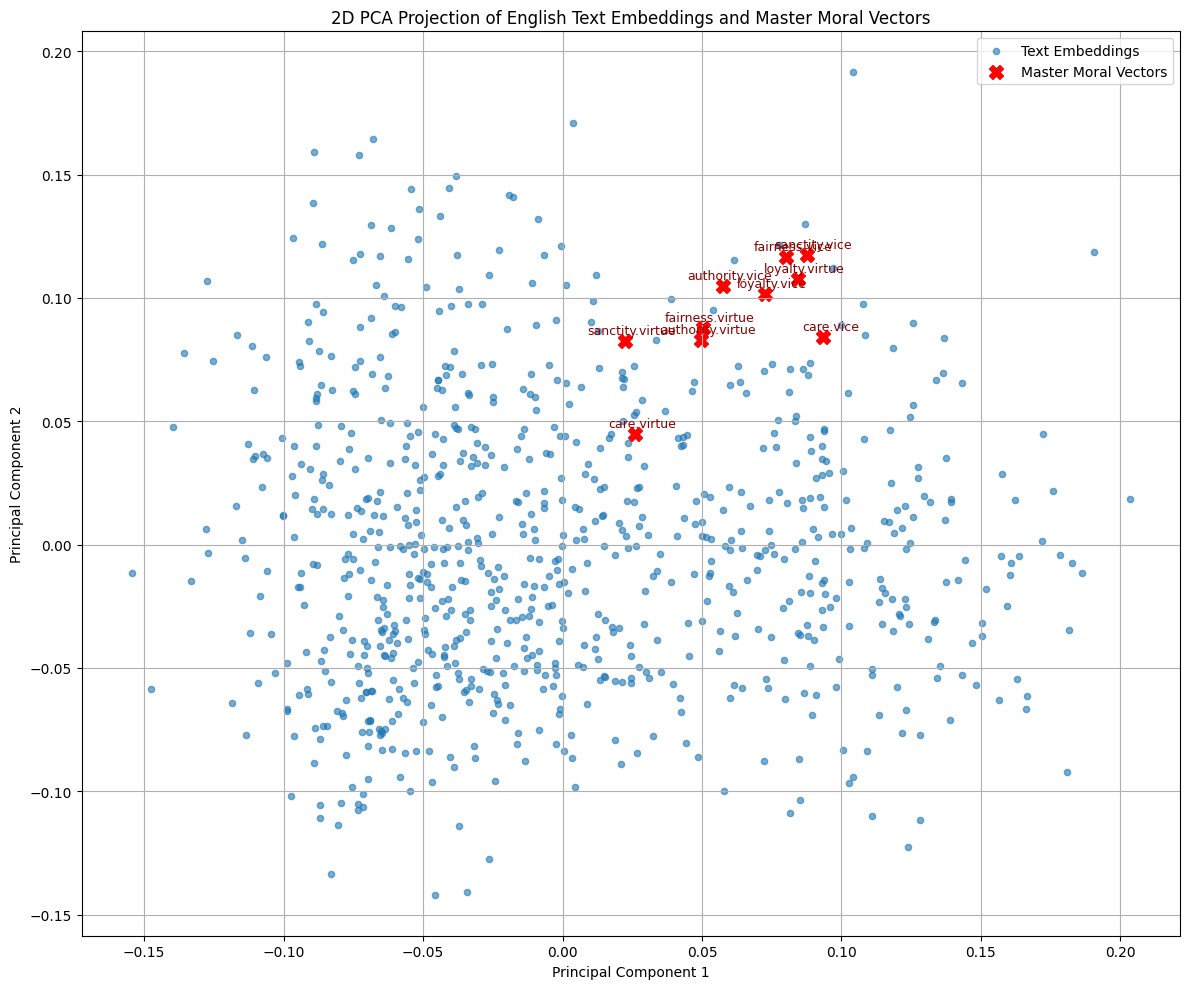

Generated PCA plot showing text embeddings and master moral vectors.


In [10]:
import matplotlib.pyplot as plt

# Create output directory for visualizations
output_dir = './english-step3-results'
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 10))

# Plot reduced text embeddings
plt.scatter(
    reduced_text_embeddings[:, 0],
    reduced_text_embeddings[:, 1],
    alpha=0.6,
    label='Text Embeddings',
    s=20
)

# Plot reduced master moral vectors
plt.scatter(
    reduced_master_moral_vectors[:, 0],
    reduced_master_moral_vectors[:, 1],
    color='red',
    s=100,
    marker='X',
    label='Master Moral Vectors'
)

# Annotate master moral vectors
for i, foundation_name in enumerate(master_moral_vectors_english.keys()):
    plt.annotate(
        foundation_name,
        (reduced_master_moral_vectors[i, 0], reduced_master_moral_vectors[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),
        ha='center',
        fontsize=9,
        color='darkred'
    )

plt.title('2D PCA Projection of English Text Embeddings and Master Moral Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
pca_plot_path = os.path.join(output_dir, 'english_pca_visualization.png')
plt.savefig(pca_plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved PCA plot to {pca_plot_path}")

plt.show()
print("Generated PCA plot showing text embeddings and master moral vectors.")

# Method 1: Aggregate Moral Scores per Text (Average)

For each text file, consolidate the cosine similarity scores by averaging across all texts.

In [11]:
# Initialize dictionaries
aggregated_moral_scores = {}
text_counts = {}

# Get all moral foundations
moral_foundations = list(master_moral_vectors_english.keys())

# Iterate through text_moral_scores
for (filename, text_index), current_text_scores in text_moral_scores.items():
    # Initialize entries if they don't exist
    if filename not in aggregated_moral_scores:
        aggregated_moral_scores[filename] = {foundation: 0.0 for foundation in moral_foundations}
        text_counts[filename] = 0
    
    # Add current scores
    for foundation, score in current_text_scores.items():
        aggregated_moral_scores[filename][foundation] += score
    
    # Increment count
    text_counts[filename] += 1

# Calculate average scores
file_average_moral_scores = {}
for filename in aggregated_moral_scores:
    average_scores_for_file = {}
    for foundation in moral_foundations:
        if text_counts[filename] > 0:
            average_scores_for_file[foundation] = aggregated_moral_scores[filename][foundation] / text_counts[filename]
        else:
            average_scores_for_file[foundation] = 0.0
    file_average_moral_scores[filename] = average_scores_for_file

print(f"Aggregated moral scores for {len(file_average_moral_scores)} texts.")
print("\nExample for the first text:")
if file_average_moral_scores:
    first_filename = list(file_average_moral_scores.keys())[0]
    print(f"  Filename: {first_filename}")
    print(f"  Average Scores: {file_average_moral_scores[first_filename]}")

Aggregated moral scores for 6 texts.

Example for the first text:
  Filename: just_so_stories_cleaned.csv
  Average Scores: {'care.virtue': np.float32(0.25549796), 'care.vice': np.float32(0.22300823), 'fairness.virtue': np.float32(0.23163866), 'fairness.vice': np.float32(0.22923921), 'loyalty.virtue': np.float32(0.25514236), 'loyalty.vice': np.float32(0.24534273), 'authority.virtue': np.float32(0.27699485), 'authority.vice': np.float32(0.2395619), 'sanctity.virtue': np.float32(0.29735255), 'sanctity.vice': np.float32(0.27463225)}


In [12]:
# Save aggregated moral scores
if file_average_moral_scores:
    print(f"Saving aggregated moral scores for {len(file_average_moral_scores)} texts...")
    for filename, scores in file_average_moral_scores.items():
        # Convert to DataFrame
        scores_df = pd.DataFrame(pd.Series(scores), columns=['average_score'])
        
        # Define output path
        output_filepath = os.path.join(output_dir, f"{filename.replace('.csv', '')}_moral_summary.csv")
        
        # Save to CSV
        scores_df.to_csv(output_filepath, index_label='Moral Foundation')
        print(f"  ✓ Saved {filename} moral summary to {output_filepath}")
else:
    print("Error: No aggregated scores to save.")

Saving aggregated moral scores for 6 texts...
  ✓ Saved just_so_stories_cleaned.csv moral summary to ./english-step3-results/just_so_stories_cleaned_moral_summary.csv
  ✓ Saved hans_christian_andersen_cleaned.csv moral summary to ./english-step3-results/hans_christian_andersen_cleaned_moral_summary.csv
  ✓ Saved morals_manners_cleaned.csv moral summary to ./english-step3-results/morals_manners_cleaned_moral_summary.csv
  ✓ Saved grimm_tales_cleaned.csv moral summary to ./english-step3-results/grimm_tales_cleaned_moral_summary.csv
  ✓ Saved peter_rabbit_cleaned.csv moral summary to ./english-step3-results/peter_rabbit_cleaned_moral_summary.csv
  ✓ Saved aesops_fables_cleaned.csv moral summary to ./english-step3-results/aesops_fables_cleaned_moral_summary.csv


## Identify Most Prevalent Moral Foundation

For each text, determine the moral foundation with the highest average cosine similarity score.

In [13]:
most_prevalent_morals = {}

for filename, average_scores_for_file in file_average_moral_scores.items():
    if average_scores_for_file:
        max_foundation = max(average_scores_for_file, key=average_scores_for_file.get)
        max_score = average_scores_for_file[max_foundation]
        
        most_prevalent_morals[filename] = {
            'most_prevalent_foundation': max_foundation,
            'score': max_score
        }
    else:
        most_prevalent_morals[filename] = {
            'most_prevalent_foundation': 'None',
            'score': 0.0
        }

print("Most prevalent moral foundation for each text:")
for filename, data in most_prevalent_morals.items():
    print(f"  {filename}: {data['most_prevalent_foundation']} (score: {data['score']:.4f})")

Most prevalent moral foundation for each text:
  just_so_stories_cleaned.csv: sanctity.virtue (score: 0.2974)
  hans_christian_andersen_cleaned.csv: sanctity.virtue (score: 0.3061)
  morals_manners_cleaned.csv: care.virtue (score: 0.2872)
  grimm_tales_cleaned.csv: care.virtue (score: 0.3276)
  peter_rabbit_cleaned.csv: authority.virtue (score: 0.2278)
  aesops_fables_cleaned.csv: authority.virtue (score: 0.3076)


✓ Saved bar plot to ./english-step3-results/just_so_stories_cleaned_average_scores.png


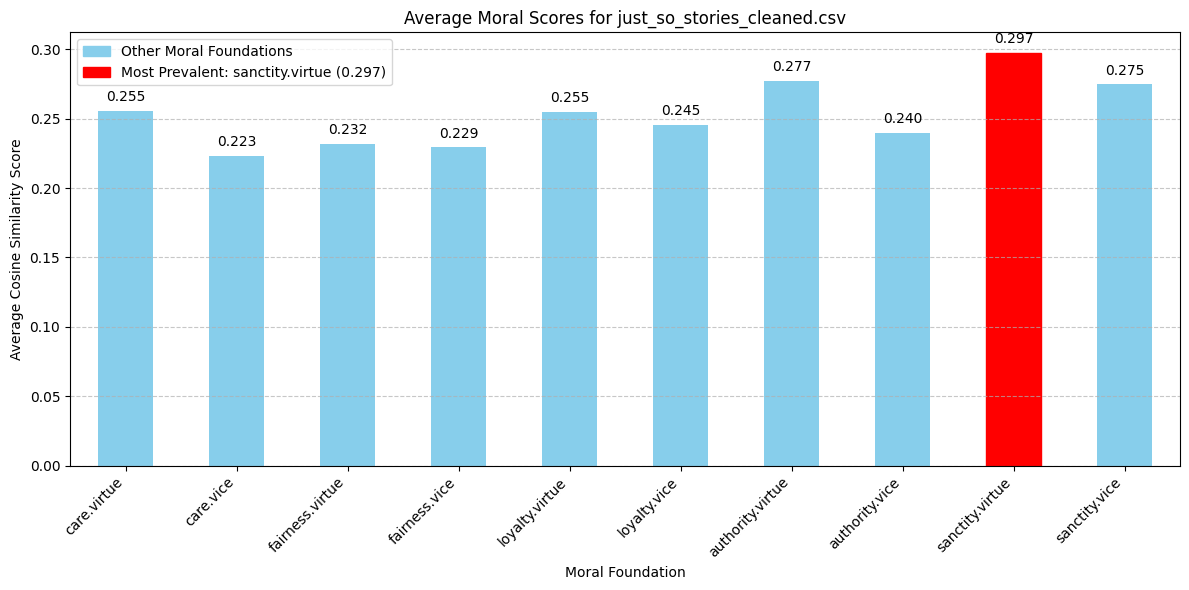

Generated bar plot for just_so_stories_cleaned.csv.
✓ Saved bar plot to ./english-step3-results/hans_christian_andersen_cleaned_average_scores.png


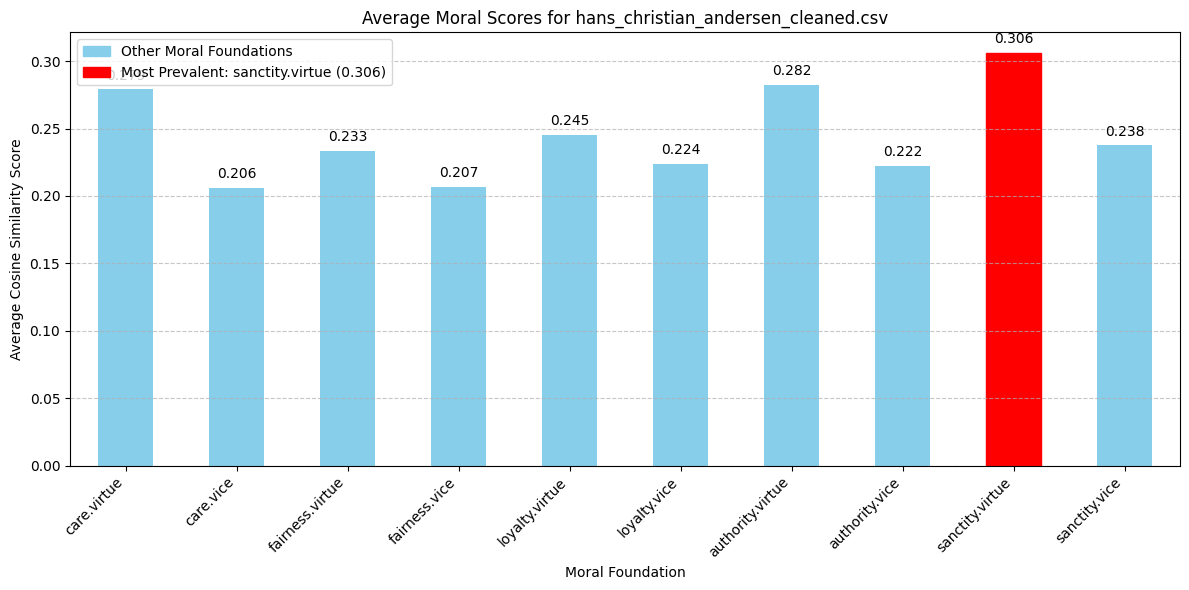

Generated bar plot for hans_christian_andersen_cleaned.csv.
✓ Saved bar plot to ./english-step3-results/morals_manners_cleaned_average_scores.png


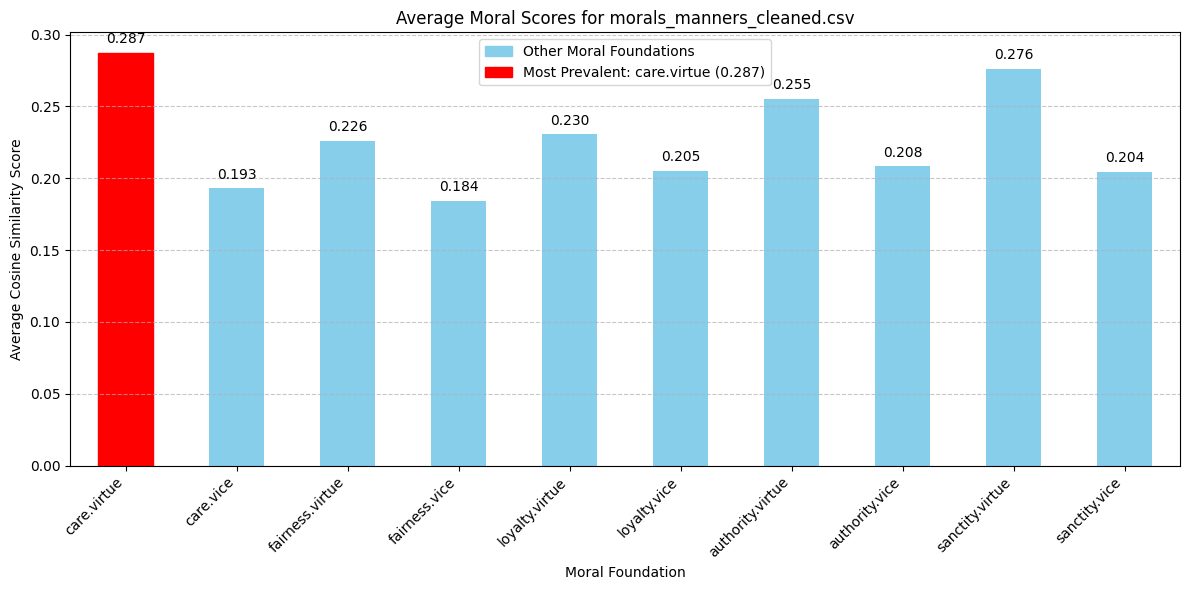

Generated bar plot for morals_manners_cleaned.csv.
✓ Saved bar plot to ./english-step3-results/grimm_tales_cleaned_average_scores.png


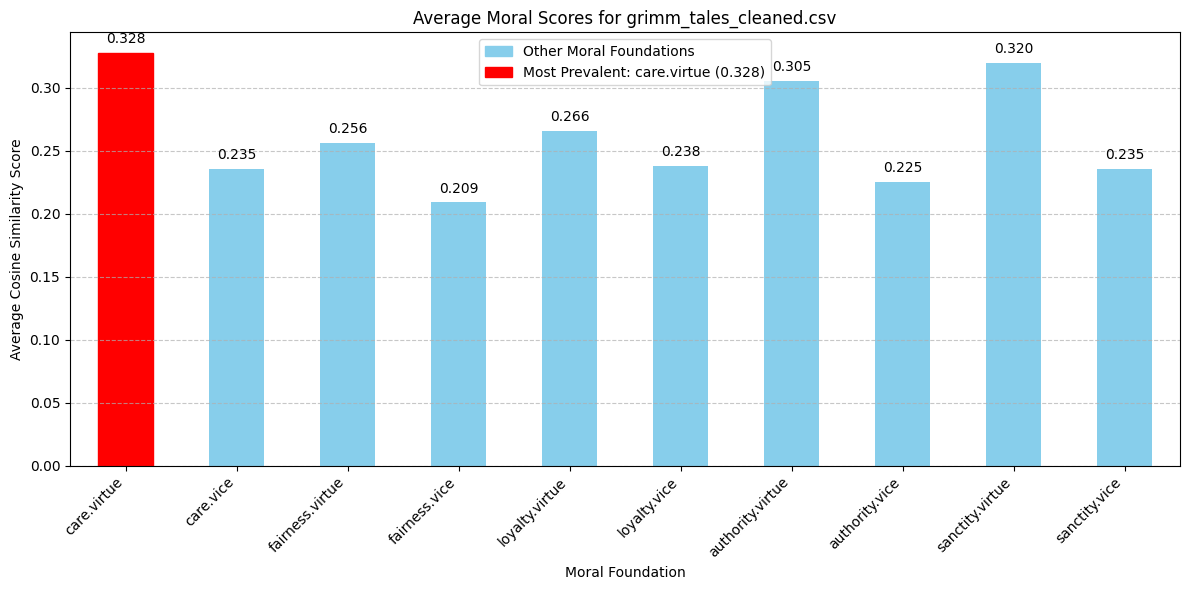

Generated bar plot for grimm_tales_cleaned.csv.
✓ Saved bar plot to ./english-step3-results/peter_rabbit_cleaned_average_scores.png


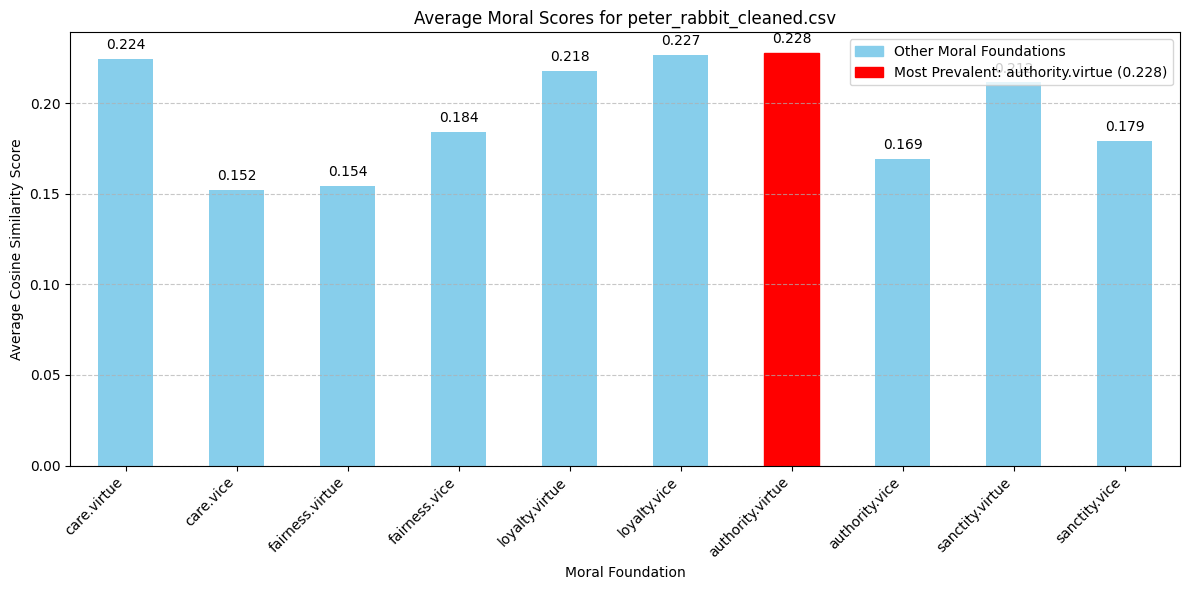

Generated bar plot for peter_rabbit_cleaned.csv.
✓ Saved bar plot to ./english-step3-results/aesops_fables_cleaned_average_scores.png


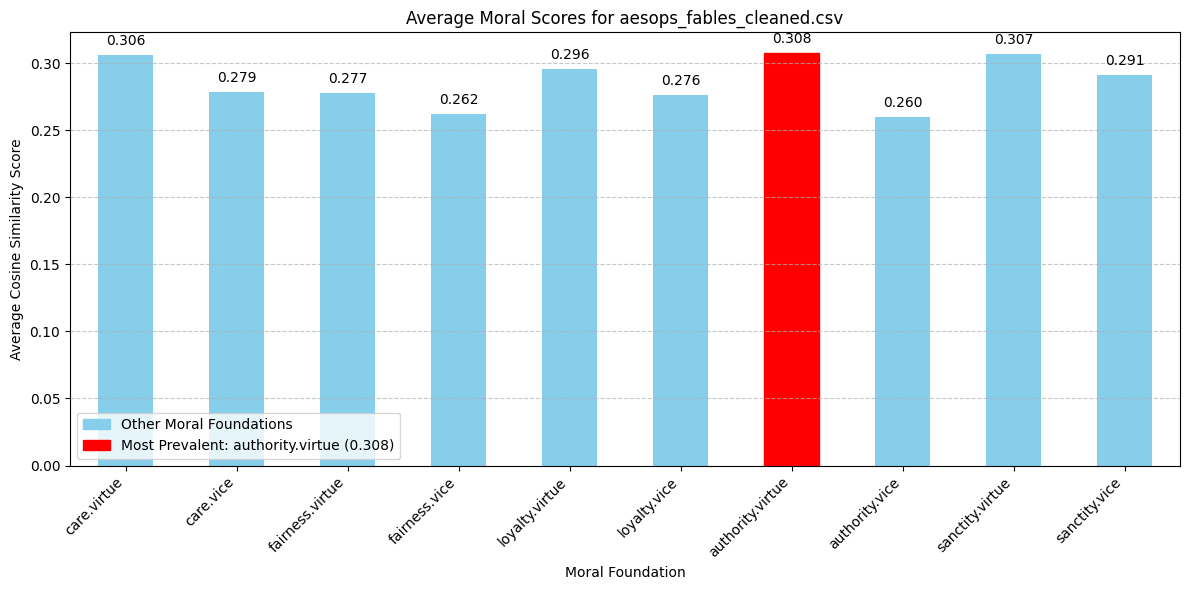

Generated bar plot for aesops_fables_cleaned.csv.


In [14]:
from matplotlib.patches import Patch

for filename, scores in file_average_moral_scores.items():
    scores_series = pd.Series(scores)
    
    plt.figure(figsize=(12, 6))
    ax = scores_series.plot(kind='bar', color='skyblue')
    
    # Identify most prevalent
    max_foundation = max(scores, key=scores.get)
    max_score = scores[max_foundation]
    
    # Change color of max bar
    for i, foundation_name in enumerate(scores_series.index):
        if foundation_name == max_foundation:
            ax.patches[i].set_color('red')
            break
    
    # Add values on bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')
    
    plt.title(f'Average Moral Scores for {filename}')
    plt.xlabel('Moral Foundation')
    plt.ylabel('Average Cosine Similarity Score')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Legend
    legend_handles = [
        Patch(color='skyblue', label='Other Moral Foundations'),
        Patch(color='red', label=f'Most Prevalent: {max_foundation} ({max_score:.3f})')
    ]
    plt.legend(handles=legend_handles)
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = filename.replace('.csv', '_average_scores.png')
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved bar plot to {plot_path}")
    
    plt.show()
    print(f"Generated bar plot for {filename}.")

# Method 2: Dominant Moral Distribution (Better Method)

**Note:** Cosine similarity doesn't capture variation/ranks well.
We will identify a "dominant" moral through distribution method.

## Identify Dominant Moral Foundation per Text

For each text, determine the moral foundation with the highest cosine similarity score.

In [15]:
dominant_moral_per_text = {}

for (filename, text_index), scores in text_moral_scores.items():
    if scores:
        dominant_foundation = max(scores, key=scores.get)
        dominant_score = scores[dominant_foundation]
        
        dominant_moral_per_text[(filename, text_index)] = {
            'dominant_foundation': dominant_foundation,
            'score': dominant_score
        }
    else:
        dominant_moral_per_text[(filename, text_index)] = {
            'dominant_foundation': 'None',
            'score': 0.0
        }

print(f"Identified dominant moral foundation for {len(dominant_moral_per_text)} texts.")
print("\nExample for the first text:")
if dominant_moral_per_text:
    first_key = list(dominant_moral_per_text.keys())[0]
    print(f"  Key: {first_key}")
    print(f"  Dominant Foundation: {dominant_moral_per_text[first_key]['dominant_foundation']}")
    print(f"  Score: {dominant_moral_per_text[first_key]['score']:.4f}")

Identified dominant moral foundation for 840 texts.

Example for the first text:
  Key: ('just_so_stories_cleaned.csv', 0)
  Dominant Foundation: sanctity.vice
  Score: 0.4641


## Export Text-Level Moral Scores to CSV

Generate detailed CSV files containing text-level information including text number, text content, all moral foundation scores, dominant moral, and dominant score.

In [16]:
print("Generating text-level CSV files for each file...")
print("=" * 80)

# Process each file
for filename in file_embeddings.keys():
    print(f"\nProcessing: {filename}")
    
    # Get original dataframe
    df = file_dataframes[filename]
    
    # Determine text column
    text_col = None
    for col in ['text', 'story', 'fable', 'tale', 'content']:
        if col in df.columns:
            text_col = col
            break
    
    # If not found, look for long-form text columns
    if text_col is None:
        for col in df.columns:
            if df[col].dtype == 'object' and col.lower() not in ['title', 'number', 'id']:
                avg_len = df[col].astype(str).str.len().mean()
                if avg_len > 50:
                    text_col = col
                    break
    
    if text_col is None:
        print(f"  Warning: No text column found. Skipping.")
        continue
    
    # Collect data
    rows = []
    
    for (file, text_idx), scores in text_moral_scores.items():
        if file == filename:
            # Get text content
            text_content = df.iloc[text_idx][text_col] if text_idx < len(df) else ""
            
            # Get title if available
            title = ""
            for title_col in ['title', 'name', 'heading']:
                if title_col in df.columns:
                    title = df.iloc[text_idx][title_col] if text_idx < len(df) else ""
                    break
            
            # Get dominant moral info
            dominant_info = dominant_moral_per_text.get((file, text_idx), {})
            dominant_moral = dominant_info.get('dominant_foundation', 'None')
            dominant_score = dominant_info.get('score', 0.0)
            
            # Build row
            row = {
                'text_number': text_idx + 1,
                'title': title,
                'text': text_content
            }
            
            # Add all moral foundation scores
            for foundation in moral_foundations:
                row[foundation] = scores.get(foundation, 0.0)
            
            # Add dominant moral and score
            row['dominant_moral'] = dominant_moral
            row['dominant_score'] = dominant_score
            
            rows.append(row)
    
    # Create DataFrame
    if rows:
        df_output = pd.DataFrame(rows)
        df_output = df_output.sort_values('text_number')
        
        # Save to CSV
        output_filename = filename.replace('.csv', '_moral_scores.csv')
        output_path = os.path.join(output_dir, output_filename)
        df_output.to_csv(output_path, index=False, encoding='utf-8')
        
        print(f"  ✓ Saved {len(rows)} texts to {output_path}")
        print(f"    Columns: {', '.join(df_output.columns)}")
    else:
        print(f"  ⚠ No data found for {filename}")

print("\n" + "=" * 80)
print(f"✓ CSV export complete! Files saved to {output_dir}/")

Generating text-level CSV files for each file...

Processing: just_so_stories_cleaned.csv
  ✓ Saved 12 texts to ./english-step3-results/just_so_stories_cleaned_moral_scores.csv
    Columns: text_number, title, text, care.virtue, care.vice, fairness.virtue, fairness.vice, loyalty.virtue, loyalty.vice, authority.virtue, authority.vice, sanctity.virtue, sanctity.vice, dominant_moral, dominant_score

Processing: hans_christian_andersen_cleaned.csv
  ✓ Saved 202 texts to ./english-step3-results/hans_christian_andersen_cleaned_moral_scores.csv
    Columns: text_number, title, text, care.virtue, care.vice, fairness.virtue, fairness.vice, loyalty.virtue, loyalty.vice, authority.virtue, authority.vice, sanctity.virtue, sanctity.vice, dominant_moral, dominant_score

Processing: morals_manners_cleaned.csv
  ✓ Saved 131 texts to ./english-step3-results/morals_manners_cleaned_moral_scores.csv
    Columns: text_number, title, text, care.virtue, care.vice, fairness.virtue, fairness.vice, loyalty.virt

## Aggregate Dominant Morals per Text

Count the occurrences of each dominant moral foundation in each text file.

In [17]:
file_dominant_foundation_counts = {}

for (filename, text_index), data in dominant_moral_per_text.items():
    dominant_foundation = data['dominant_foundation']
    
    if filename not in file_dominant_foundation_counts:
        file_dominant_foundation_counts[filename] = {}
    
    file_dominant_foundation_counts[filename][dominant_foundation] = \
        file_dominant_foundation_counts[filename].get(dominant_foundation, 0) + 1

print(f"Aggregated dominant moral foundation counts for {len(file_dominant_foundation_counts)} texts.")
print("\nExample for the first text:")
if file_dominant_foundation_counts:
    first_filename = list(file_dominant_foundation_counts.keys())[0]
    print(f"  Filename: {first_filename}")
    print(f"  Dominant Foundation Counts: {file_dominant_foundation_counts[first_filename]}")

Aggregated dominant moral foundation counts for 6 texts.

Example for the first text:
  Filename: just_so_stories_cleaned.csv
  Dominant Foundation Counts: {'sanctity.vice': 3, 'sanctity.virtue': 5, 'loyalty.virtue': 1, 'authority.vice': 1, 'care.virtue': 1, 'authority.virtue': 1}


## Normalize and Visualize Dominant Moral Distributions

Convert counts to proportions and generate visualizations.

In [18]:
file_dominant_foundation_proportions = {}

for filename, foundation_counts in file_dominant_foundation_counts.items():
    total_texts_in_file = text_counts.get(filename, 0)
    
    if total_texts_in_file > 0:
        proportions = {
            foundation: count / total_texts_in_file
            for foundation, count in foundation_counts.items()
        }
        file_dominant_foundation_proportions[filename] = proportions
    else:
        file_dominant_foundation_proportions[filename] = {}

print("Calculated dominant moral foundation proportions for each text.")
for filename, proportions in file_dominant_foundation_proportions.items():
    print(f"\n  {filename}:")
    for foundation, prop in sorted(proportions.items(), key=lambda x: x[1], reverse=True):
        print(f"    {foundation}: {prop*100:.1f}%")

Calculated dominant moral foundation proportions for each text.

  just_so_stories_cleaned.csv:
    sanctity.virtue: 41.7%
    sanctity.vice: 25.0%
    loyalty.virtue: 8.3%
    authority.vice: 8.3%
    care.virtue: 8.3%
    authority.virtue: 8.3%

  hans_christian_andersen_cleaned.csv:
    sanctity.virtue: 57.9%
    care.virtue: 17.8%
    authority.virtue: 14.9%
    loyalty.virtue: 5.9%
    sanctity.vice: 2.5%
    authority.vice: 1.0%

  morals_manners_cleaned.csv:
    care.virtue: 49.6%
    sanctity.virtue: 28.2%
    authority.virtue: 6.1%
    loyalty.virtue: 6.1%
    sanctity.vice: 3.1%
    authority.vice: 3.1%
    loyalty.vice: 2.3%
    fairness.virtue: 1.5%

  grimm_tales_cleaned.csv:
    care.virtue: 47.6%
    sanctity.virtue: 25.2%
    authority.virtue: 14.8%
    loyalty.virtue: 7.6%
    sanctity.vice: 3.3%
    authority.vice: 0.5%
    care.vice: 0.5%
    loyalty.vice: 0.5%

  peter_rabbit_cleaned.csv:
    authority.virtue: 100.0%

  aesops_fables_cleaned.csv:
    care.virtue: 27

✓ Saved distribution chart to ./english-step3-results/just_so_stories_cleaned_distribution.png


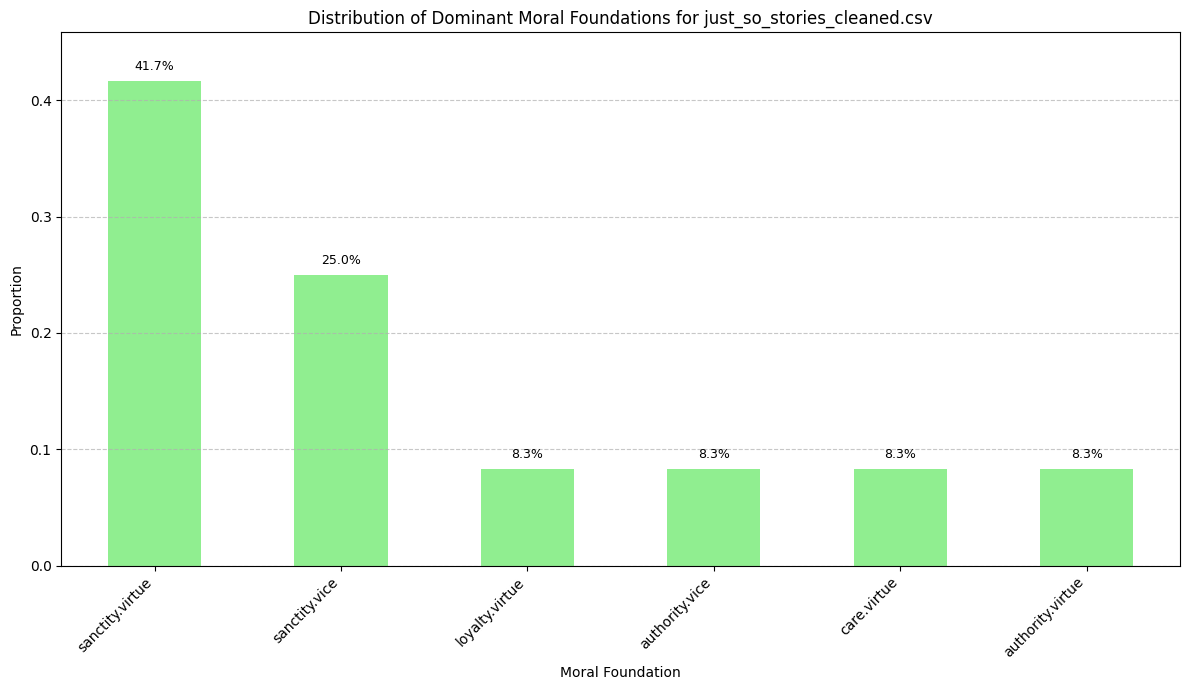

Generated distribution bar chart for just_so_stories_cleaned.csv.
✓ Saved distribution chart to ./english-step3-results/hans_christian_andersen_cleaned_distribution.png


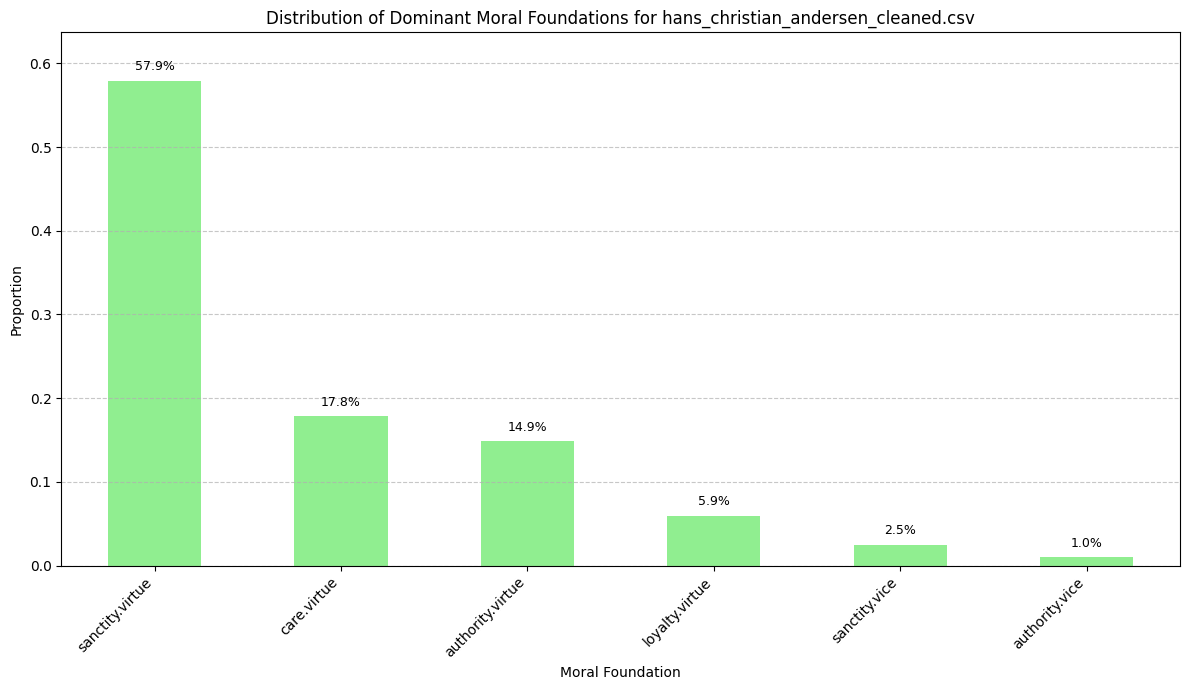

Generated distribution bar chart for hans_christian_andersen_cleaned.csv.
✓ Saved distribution chart to ./english-step3-results/morals_manners_cleaned_distribution.png


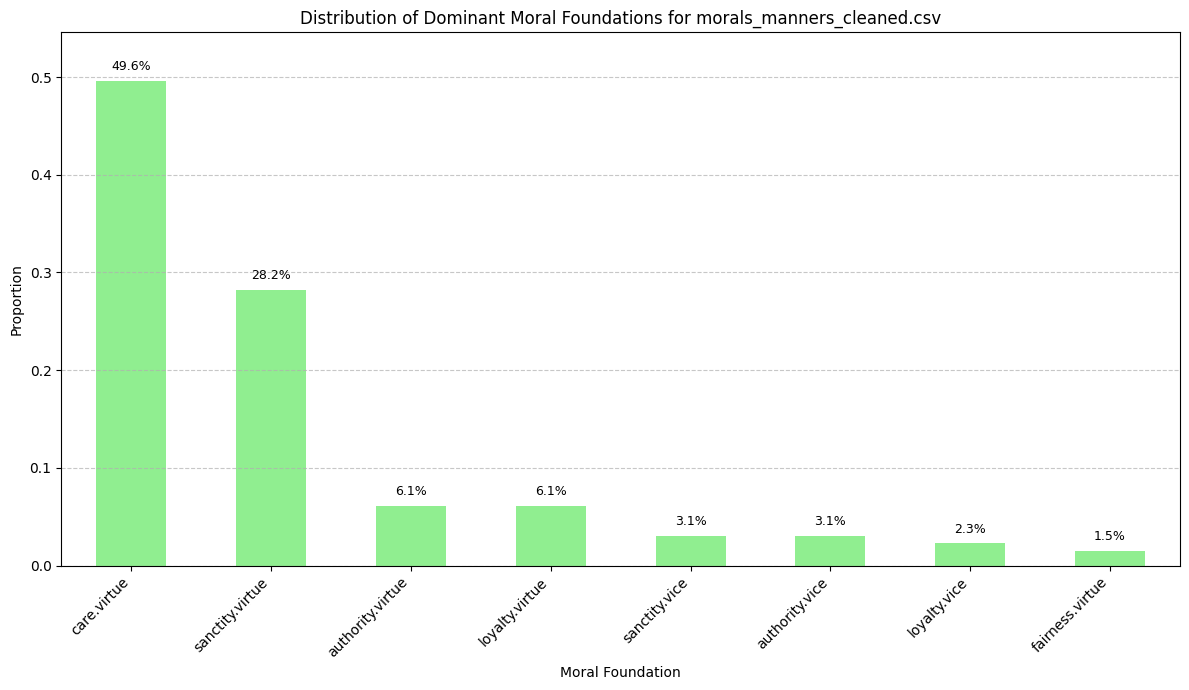

Generated distribution bar chart for morals_manners_cleaned.csv.
✓ Saved distribution chart to ./english-step3-results/grimm_tales_cleaned_distribution.png


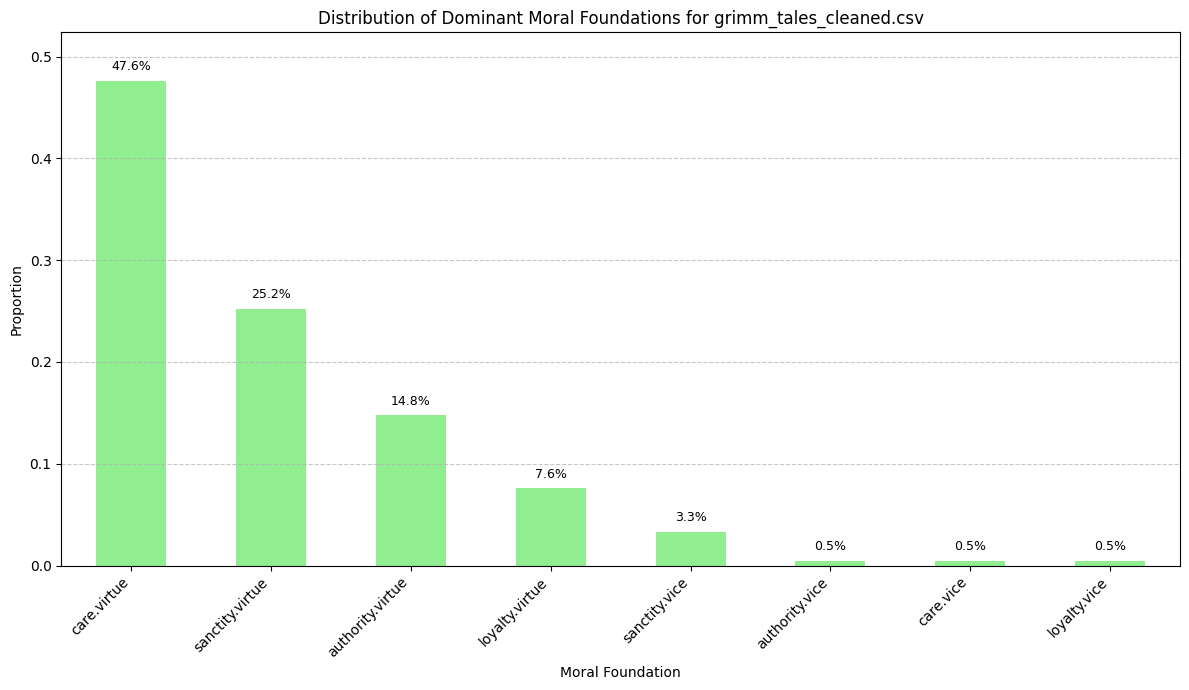

Generated distribution bar chart for grimm_tales_cleaned.csv.
✓ Saved distribution chart to ./english-step3-results/peter_rabbit_cleaned_distribution.png


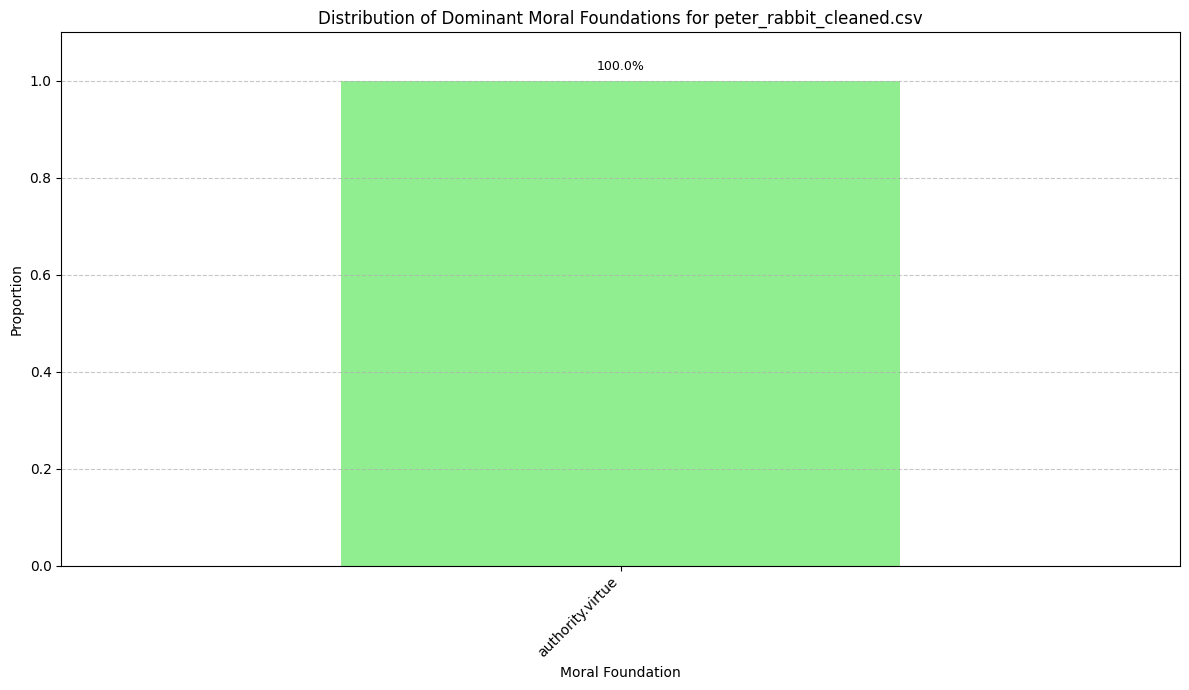

Generated distribution bar chart for peter_rabbit_cleaned.csv.
✓ Saved distribution chart to ./english-step3-results/aesops_fables_cleaned_distribution.png


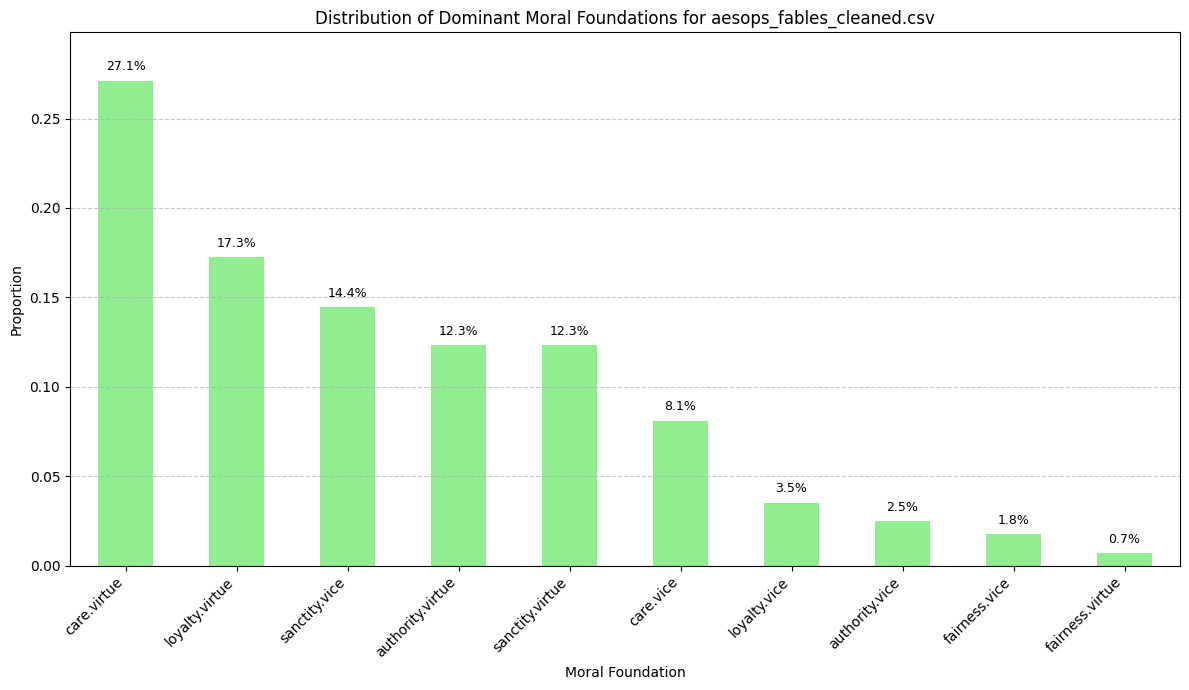

Generated distribution bar chart for aesops_fables_cleaned.csv.


In [19]:
for filename, proportions in file_dominant_foundation_proportions.items():
    if not proportions:
        print(f"No dominant moral foundations to visualize for {filename}.")
        continue
    
    proportions_series = pd.Series(proportions)
    proportions_series = proportions_series.sort_values(ascending=False)
    
    plt.figure(figsize=(12, 7))
    ax = proportions_series.plot(kind='bar', color='lightgreen')
    
    # Add percentage values on bars
    for p in ax.patches:
        percentage = f"{p.get_height() * 100:.1f}%"
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=9)
    
    plt.title(f'Distribution of Dominant Moral Foundations for {filename}')
    plt.xlabel('Moral Foundation')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(proportions_series.values) * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot
    plot_filename = filename.replace('.csv', '_distribution.png')
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved distribution chart to {plot_path}")
    
    plt.show()
    print(f"Generated distribution bar chart for {filename}.")

## Summary

### Data Analysis Key Findings:
* Calculated moral foundation scores for all English texts using cosine similarity
* Applied two methods:
  - **Method 1 (Average)**: Averaged scores across texts per file
  - **Method 2 (Dominant Distribution)**: Counted dominant moral per text and calculated proportions
* Generated PCA visualizations showing text embeddings in relation to master moral vectors
* Exported detailed CSV files with text-level moral scores
* Created distribution charts showing the breakdown of dominant morals

### Outputs:
* **Text-level CSVs**: `{text_name}_moral_scores.csv` - Contains text content, title, all 10 moral scores, dominant moral
* **Summary CSVs**: `{text_name}_moral_summary.csv` - Average scores per foundation
* **Visualizations**: PCA plots and distribution bar charts

### English Texts Analyzed:
- Aesop's Fables
- Grimm's Household Tales
- Hans Christian Andersen Fairy Tales
- Just So Stories
- Morals and Manners
- Peter Rabbit
